In [1]:
import scipy.signal as signal
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={'figure.figsize': (12, 4),'lines.linewidth': 2, 'font.size': 18, 'axes.labelsize': 16, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style('white')



In [2]:
import frank_lab


fileroot = '/Users/ckemere/Development/Data/Frank/Fra';
#fileroot = 'SampleData/Fra';



In [3]:
# These are all zero indexed in contrast to their matlab counterparts
Day = 4
Epoch = 1
Tetrode = 13

In [4]:
spikes = frank_lab.load_data(fileroot, datatype='spikes', day=Day+1)

Loading fraspikes05.mat


In [5]:
eeg = frank_lab.load_data(fileroot, day=Day+1, epoch=Epoch+1, tetrode=Tetrode+1)[Day][Epoch][Tetrode]
#eeg.__dict__ to get fields
data = eeg.data
FS = eeg.samprate
StartTime = eeg.starttime
TimeAxis = StartTime + np.array(range(len(data))) / FS

Loading fraeeg05-2-14.mat


In [6]:

b = signal.firwin(25, [150/(FS/2), 250/(FS/2)], pass_zero=False)
w,h = signal.freqz(b)
#fig = plt.figure()
#plt.plot(w/np.pi*(FS/2), 20 * np.log10(abs(h)), 'b')
#plt.xlabel('Frequency [rad/sample]')
#plt.axis('tight')
#fig.show()



In [7]:
data.shape

(1383039,)

In [8]:
# Maggie defines ripples by doing:
#  (1) filter 150-250
#  (2) hilbert envelope
#  (3) smooth with Gaussian (4 ms SD)
#  (4) 3SD above the mean for 15 ms
#  (5) full ripple defined as window back to mean

ripple_data = signal.filtfilt(b,1,data)



In [9]:
ripple_envelope = np.absolute(signal.hilbert(ripple_data))


In [10]:
import scipy.ndimage
SD = 0.004 * 1500
smoothed_envelope = scipy.ndimage.filters.gaussian_filter1d(ripple_envelope, SD,mode='constant')


In [11]:
mean_ripple_envelope = np.mean(smoothed_envelope)
std_ripple_envelope = np.std(smoothed_envelope)
mean_ripple_envelope + 3*std_ripple_envelope

21.08635530800219

In [12]:
from itertools import groupby
from operator import itemgetter

def find_threshold_crossing_events(x, threshold) :
    above_threshold = np.where(x > threshold, 1, 0);
    eventlist = []
    eventmax = []
    for k,v in groupby(enumerate(above_threshold),key=itemgetter(1)):
        if k:
            v = list(v)
            eventlist.append([v[0][0],v[-1][0]])
            try :
                eventmax.append(x[v[0][0]:(v[-1][0]+1)].max())
            except :
                print(v, x[v[0][0]:v[-1][0]])
                
    eventmax = np.asarray(eventmax)
    eventlist = np.asarray(eventlist)
    return eventlist, eventmax

In [13]:

# Find periods where value is > mean + 3 SD
ripple_events = find_threshold_crossing_events(smoothed_envelope,
                                 np.mean(smoothed_envelope) + 3*np.std(smoothed_envelope))[0]

LengthCriteria = 0.015

# Purge ripple events which aren't long enough (15 ms)
ripple_events = \
    ripple_events[ripple_events[:,1] - ripple_events[:,0] >= np.round(FS*LengthCriteria),:]

# Find periods where value is > mean; note that the previous periods should be within these!
ripple_bounds, broader_maxes = find_threshold_crossing_events(smoothed_envelope, 
                                                  np.mean(smoothed_envelope))


In [14]:
# Find corresponding big windows for potential ripple events
#  Specifically, look for closest left edge that is just smaller
outer_boundary_indices = np.searchsorted(ripple_bounds[:,0], ripple_events[:,0]);
print
#  searchsorted finds the index after, so subtract one to get index before
outer_boundary_indices = outer_boundary_indices - 1;


# Find extended boundaries for ripple events by pairing to larger windows
#   (Note that there may be repeats if the larger window contains multiple > 3SD sections)
ripple_bounds = ripple_bounds[outer_boundary_indices,:]
ripple_maxes = broader_maxes[outer_boundary_indices]

print(ripple_bounds.shape)

# Now, since all that we care about are the larger windows, so we should get rid of repeats
_, unique_idx = np.unique(ripple_bounds[:,0], return_index=True)
ripple_bounds = ripple_bounds[unique_idx,:]
ripple_maxes = ripple_maxes[unique_idx]
ripple_events = ripple_events[unique_idx,:]



(89, 2)


In [15]:
ripple_bounds.shape

(85, 2)

In [16]:
np.diff(ripple_bounds).max() / FS

0.15599998872049162

In [17]:
ripple_data_highlight = np.empty(ripple_data.shape)
ripple_data_highlight[:] = np.NAN
for r in ripple_bounds :
    ripple_data_highlight[r[0]:r[1]] = ripple_data[r[0]:r[1]]


In [18]:
ripple_centers = (ripple_bounds[:,1]/2 + ripple_bounds[:,0]/2) / FS + StartTime


In [19]:
ripple_centers.shape

(85,)

In [20]:
ripple_bounds[:5,:]/FS

array([[  7.74666611,   7.8346661 ],
       [ 21.54199844,  21.6006651 ],
       [ 21.66799843,  21.7206651 ],
       [ 23.66199829,  23.71333162],
       [ 31.46999772,  31.53933105]])

In [21]:
[cellinfo,rawcellinfo] = frank_lab.load_data(fileroot, datatype='cellinfo')
#cellinfo[pd.isnull(cellinfo['area'])]


MUAidx = cellinfo[(cellinfo['Day']==Day) & 
               (cellinfo['Epoch']==Epoch) ].index.tolist()

BinSize = 0.01 # 10 ms bins
MUAbins = np.arange(StartTime, TimeAxis[-1]+BinSize, BinSize)
print(len(MUAbins))
print(len(MUAidx))
# MUA = pd.DataFrame(index=MUAidx, columns = MUABins)
MUA = np.ndarray(shape=(len(MUAbins)-1,len(MUAidx)))
for i,cell in enumerate(MUAidx) :
    MUA[:,i] = np.histogram(spikes[cell]['data'], MUAbins)[0]

    

Loading fracellinfo00.mat
92204
49


In [22]:
TotalMUA = MUA.sum(axis=1)
MUAbins.shape

(92204,)

In [23]:
pos = frank_lab.load_data(fileroot, day=Day+1, datatype='pos')


Loading frapos05.mat


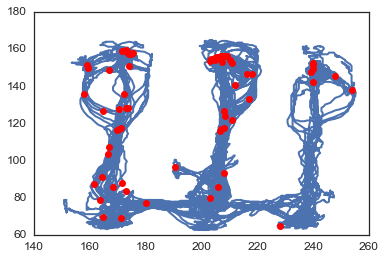

In [24]:
%matplotlib inline
plt.plot(pos[Day][Epoch].data[:,1], pos[Day][Epoch].data[:,2])
RipIdx = np.searchsorted(pos[Day][Epoch].data[:,0], ripple_centers)
plt.plot(pos[Day][Epoch].data[RipIdx,1], pos[Day][Epoch].data[RipIdx,2],'ro')
plt.show()



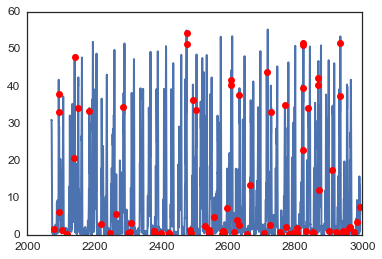

In [25]:

plt.plot(pos[Day][Epoch].data[:,0],pos[Day][Epoch].data[:,-1])
plt.plot(pos[Day][Epoch].data[RipIdx,0],pos[Day][Epoch].data[RipIdx,-1],'ro')



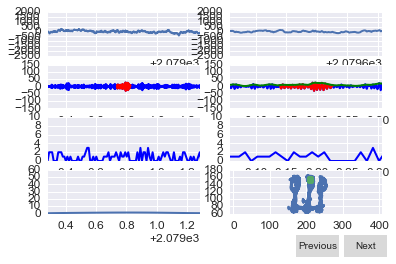

In [27]:
from matplotlib import gridspec
from matplotlib.widgets import Button
sns.set(rc={'figure.figsize': (12, 8),'lines.linewidth': 2, 'font.size': 18, 'axes.labelsize': 16, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })

%matplotlib inline
#%matplotlib notebook

plt.figure()
RippleWindowSize = 0.25 # Plot zoomed ripples in 250 ms window
LargerWindowSize = 1 # Plot context in 1 s window

gs = gridspec.GridSpec(4, 2, bottom=0.2) 
raw1 = plt.subplot(gs[0])
plt.plot(TimeAxis,data)
plt.setp(raw1.get_xticklabels(), visible=False)

raw2 = plt.subplot(gs[1])
plt.plot(TimeAxis,data)
plt.setp(raw2.get_xticklabels(), visible=False)

rip1 = plt.subplot(gs[2], sharex=raw1)
plt.plot(TimeAxis,ripple_data,'b')
plt.plot(TimeAxis,ripple_data_highlight,'r')

rip2 = plt.subplot(gs[3], sharex=raw2)
plt.plot(TimeAxis,ripple_data,'b')
plt.plot(TimeAxis,ripple_data_highlight,'r')
plt.plot(TimeAxis,smoothed_envelope,'g')

mua1 = plt.subplot(gs[4], sharex=raw1)
plt.plot(MUAbins[:-1],TotalMUA,'b')

mua1 = plt.subplot(gs[5], sharex=raw2)
plt.plot(MUAbins[:-1],TotalMUA,'b')

vel1 = plt.subplot(gs[6], sharex=raw1)
plt.plot(pos[Day][Epoch].data[:,0],pos[Day][Epoch].data[:,-1])

rip_window = [-RippleWindowSize/2,RippleWindowSize/2]
big_window = [-LargerWindowSize/2,LargerWindowSize/2]

raw2.set_xlim(rip_window + ripple_centers[0])
raw1.set_xlim(big_window + ripple_centers[0])

rip_pos = plt.subplot(gs[7])
plt.plot(pos[Day][Epoch].data[:,1], pos[Day][Epoch].data[:,2])
pltIdx = np.searchsorted(pos[Day][Epoch].data[:,0], big_window + ripple_centers[0])
plt.plot(pos[Day][Epoch].data[pltIdx[0]:pltIdx[1],1], pos[Day][Epoch].data[pltIdx[0]:pltIdx[1],2],'o')
rip_pos.set_aspect('equal','datalim')

class Index(object):
    ind = 0
    def next(self, event):
        self.ind += 1
        if (self.ind > len(ripple_centers)) :
            self.ind = 0;
        raw2.set_xlim(rip_window + ripple_centers[self.ind])
        raw1.set_xlim(big_window + ripple_centers[self.ind])
        
        rip_pos.clear()
        rip_pos.plot(pos[Day][Epoch].data[:,1], pos[Day][Epoch].data[:,2])
        pltIdx = np.searchsorted(pos[Day][Epoch].data[:,0], big_window + ripple_centers[self.ind])
        rip_pos.plot(pos[Day][Epoch].data[pltIdx[0]:pltIdx[1],1], pos[Day][Epoch].data[pltIdx[0]:pltIdx[1],2],'o')

        plt.draw()

    def prev(self, event):
        self.ind -= 1
        if (self.ind < 0) :
            self.ind = len(ripple_centers)-1;
        raw2.set_xlim(rip_window + ripple_centers[self.ind])
        raw1.set_xlim(big_window + ripple_centers[self.ind])
        
        rip_pos.clear()
        rip_pos.plot(pos[Day][Epoch].data[:,1], pos[Day][Epoch].data[:,2])
        pltIdx = np.searchsorted(pos[Day][Epoch].data[:,0], big_window + ripple_centers[self.ind])
        rip_pos.plot(pos[Day][Epoch].data[pltIdx[0]:pltIdx[1],1], pos[Day][Epoch].data[pltIdx[0]:pltIdx[1],2],'o')

        plt.draw()

callback = Index()
axprev = plt.axes([0.7, 0.05, 0.1, 0.075])
axnext = plt.axes([0.81, 0.05, 0.1, 0.075])
bnext = Button(axnext, 'Next')
bnext.on_clicked(callback.next)
bprev = Button(axprev, 'Previous')
bprev.on_clicked(callback.prev)


plt.show()
